In [1]:
from settings import *

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

prices는 현재 공휴일이 제외 되지 않았다. 

TODO:

1. 공휴일 제외 데이터를 만들어서(kospi기준) 백테스팅 필요

In [3]:
prices = pd.read_csv('data/dollar_assets.csv', index_col=0, parse_dates=True)
prices.head(1)

,달러,나스닥100,다우
Date,,,
2001-01-02,1278.000,11660.355,5042.930


<AxesSubplot:xlabel='Date'>

                 달러    나스닥100        다우     나스닥100_1      다우_1
Date                                                          
2001-01-02 1278.000 11660.355  5042.930  2720580.840 44487.180
2001-01-03 1270.500 13767.882  5154.618  3212306.790 44708.895
2001-01-04 1263.300 13319.834  5110.000  3107768.532 46502.073
2001-01-05 1262.500 12271.450  4989.785  2863160.625 43871.875
2001-01-06 1262.500 12271.450  4989.785  2863160.625 43871.875
...             ...       ...       ...          ...       ...
2020-06-28 1203.800 54285.000 15374.000 11856659.568 47911.240
2020-06-29 1199.160 52844.000 14994.000 11945024.626 49141.577
2020-06-30 1199.280 53676.000 15240.000 12180907.068 48882.653
2020-07-01 1201.510 54445.000 15270.000 12350621.668 48961.533
2020-07-02 1198.750 55322.000 15319.000 12397340.637 49856.013

[7122 rows x 5 columns]


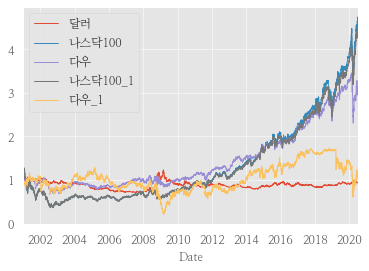

In [4]:
p = pd.read_csv('data/assets.csv', index_col=0, parse_dates=True)
df = prices.copy()
df['나스닥100_1'] = p['나스닥100']*prices['달러']
df['다우_1'] = p['다우']*prices['달러']

df.dropna().rebase(1).plot();
print(df)

In [5]:
data = pd.read_csv("/Users/hosung/workspace/git/docu/data/asset_db.csv", index_col=0, parse_dates=True)
data.sample()

,kbond20y,vn30,kbond1y,uscorp15_UH,usenergy_UH,usdkrw,usbond30y_H,kbond10y,eurkrw,em_H,topx100,nasdaq100_H,cnykrw,world_UH,csi300,us500_UH,dji_UH,gold_H,kodex200x2,jpykrw,nasdaq100_UH,reit_H,kbond3y,kodex200,copper_UH,us500_H,usbond10y_UH,usdkrwx2
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-11-12,38113.994,NaN,70952.992,42381.322,3702.558,1172.900,5066.641,54656.766,1364.730,4043.017,7579.469,2632.734,141.710,4775.063,1270.791,2237.900,4462.735,2656.726,3553.844,10.777,7256.613,3053.878,61315.271,7576.000,2790.715,9373.739,6272.818,8980.562


<AxesSubplot:xlabel='Date'>

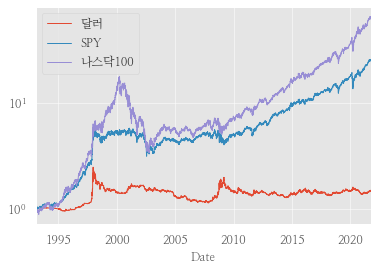

In [28]:
prices = data[['usdkrw', 'us500_UH', 'nasdaq100_UH']].copy()
prices.columns = ['달러','SPY', '나스닥100']
prices = prices.resample('D').first().fillna(method="ffill")
prices.dropna().rebase(1).plot(logy=True)
prices = prices['2001-01-02':'2020-07-02']
prices.to_csv("dollar_assets.csv")

In [29]:
def AMS(x):
    ''' x : Series (DataFrame의 컬럼)
        x[-1] : 기준일. x의 현재값
        (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
        => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
    '''
    # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
    return np.mean(np.where(x[-1]>x, 1, 0)[:-1]) # 당일 날짜 비교는 제외해준다 [:-1]    

In [30]:
target_weights = pd.DataFrame()
for c in ["SPY", "나스닥100"]:
    target_weights[c] = prices[c].rolling(365).apply(AMS)
target_weights = target_weights *0.5# 다우 나스닥은 2개여서 0.5였음
target_weights['달러'] = 1.0 - target_weights.sum(axis=1)

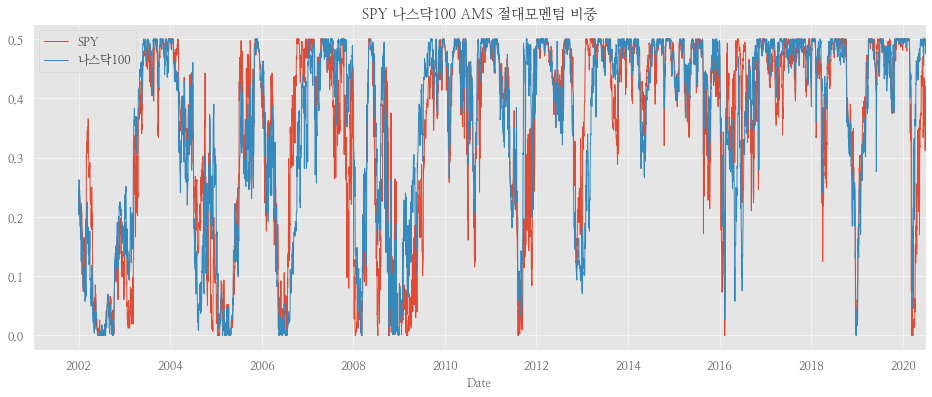

In [31]:
target_weights[["SPY", "나스닥100"]].plot(figsize=(16,6), title='SPY 나스닥100 AMS 절대모멘텀 비중', legend=True);

In [32]:
tickers = prices.columns
tickers

Index(['달러', 'SPY', '나스닥100'], dtype='object')

In [33]:
SPY나스닥동일비중 =bt.Strategy(
    "SPY나스닥동일비중",
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectThese(['SPY', '나스닥100']),
        bt.algos.WeighEqually(),
#         bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ]
)

In [36]:
SPY나스닥동일비중AMS = bt.Strategy(
    'SPY나스닥동일비중AMS',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectThese(['SPY', '나스닥100', '달러']),
        bt.algos.WeighTarget(target_weights),
        # WeighEquallyWithoutCash(target_weights, cash='현금'),
#         bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ]
)

In [47]:
def long_only_ew(data, name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate('2002-02-01'),
                           bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, data, initial_capital=100000000.0)

In [48]:
bt_spy = long_only_ew(prices[['SPY']], 'SPY')
bt_nasdaq = long_only_ew(prices[['나스닥100']], '나스닥100')
bt_dollar = long_only_ew(prices[['달러']], '달러')
bt_SPY나스닥동일비중 = bt.Backtest(SPY나스닥동일비중, prices)
bt_SPY나스닥동일비중AMS = bt.Backtest(SPY나스닥동일비중AMS,  prices)
r = bt.run(bt_SPY나스닥동일비중, bt_SPY나스닥동일비중AMS, bt_spy, bt_nasdaq, bt_dollar)

In [49]:
r.set_date_range("2002-02-01") 
r.display()

Stat                 SPY나스닥동일비중    SPY나스닥동일비중AMS    SPY         나스닥100    달러
-------------------  -------------------  ----------------------  ----------  -----------  ----------
Start                2002-02-01           2002-02-01              2002-02-01  2002-02-01   2002-02-01
End                  2020-07-02           2020-07-02              2020-07-02  2020-07-02   2020-07-02
Risk-free rate       0.00%                0.00%                   0.00%       0.00%        0.00%

Total Return         391.54%              213.85%                 263.49%     543.46%      -8.67%
Daily Sharpe         0.44                 0.43                    0.37        0.45         0.01
Daily Sortino        0.70                 0.66                    0.58        0.72         0.01
CAGR                 9.03%                6.41%                   7.26%       10.64%       -0.49%
Max Drawdown         -43.92%              -22.06%                 -39.88%     -51.22%      -35.74%
Calmar Ratio         0.21       

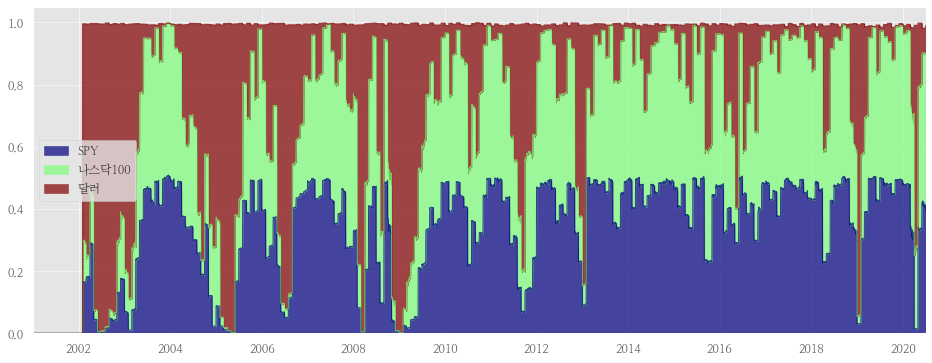

In [50]:
r.get_security_weights('SPY나스닥동일비중AMS').plot.area(stacked=True, alpha=0.7, legend=True, cmap='jet', figsize=(16,6));

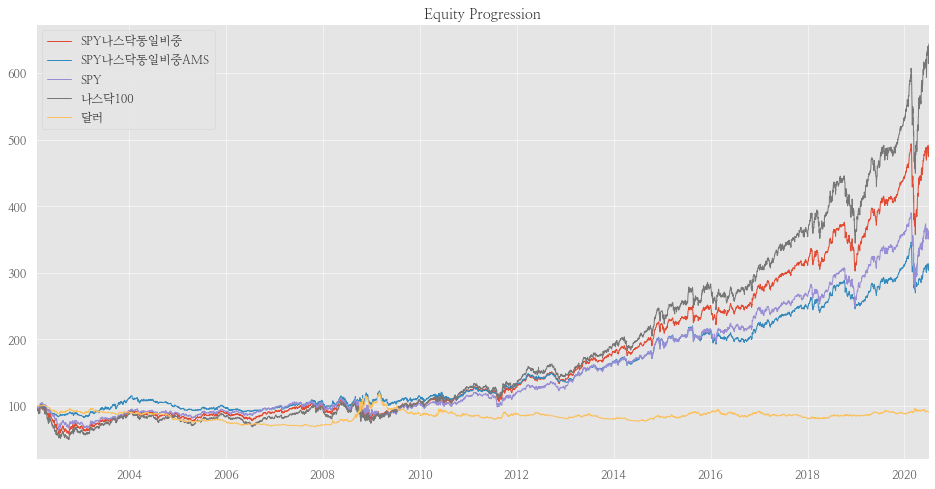

In [51]:
ax = r.plot(figsize=(16,8));
plt.legend(loc="upper left");

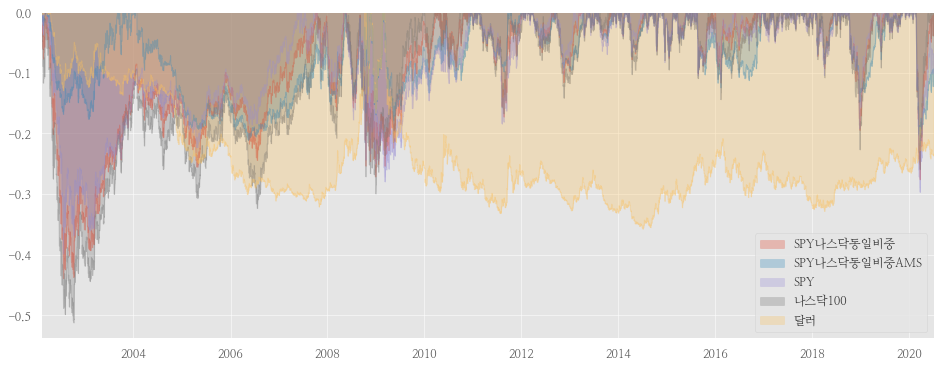

In [52]:
r.prices.to_drawdown_series().plot.area(stacked=False, alpha=0.3, figsize=(16, 6));

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2002-02-02  2002-02-02
End Period                 2020-07-02  2020-07-02
Risk-Free Rate             0.0%        0.0%
Time in Market             69.0%       68.0%

Cumulative Return          213.85%     391.54%
CAGR﹪                     6.4%        9.03%

Sharpe                     0.43        0.44
Smart Sharpe               0.4         0.41
Sortino                    0.62        0.65
Smart Sortino              0.57        0.6
Sortino/√2                 0.44        0.46
Smart Sortino/√2           0.41        0.43
Omega                      1.11        1.11

Max Drawdown               -22.06%     -43.92%
Longest DD Days            1736        2033
Volatility (ann.)          11.37%      16.5%
R^2                        0.66        0.66
Calmar                     0.29        0.21
Skew                       0.25        0.72
Kurtosis                   33.68       22.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-21,2020-03-23,2020-07-02,132,-22.061,-20.285
2,2004-01-27,2006-05-17,2008-10-28,1736,-21.159,-20.278
3,2009-03-03,2009-05-13,2010-12-17,654,-17.822,-16.992
4,2002-03-20,2003-01-27,2003-09-02,531,-17.642,-17.200
5,2008-11-25,2008-12-30,2009-02-27,94,-16.922,-16.713


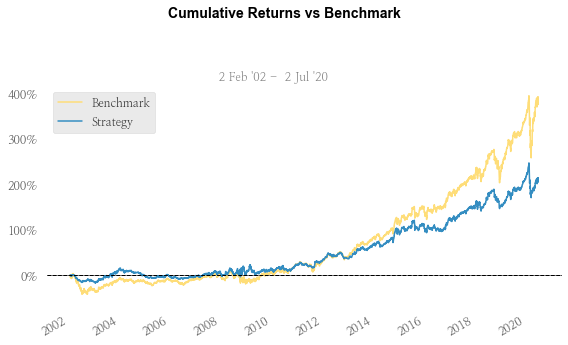

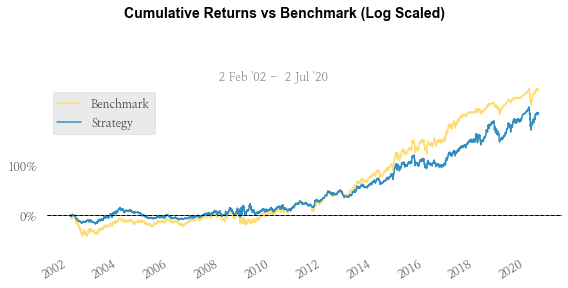

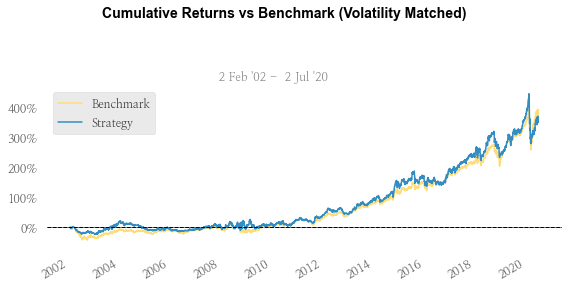

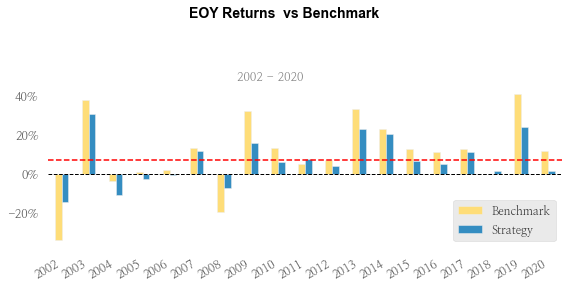

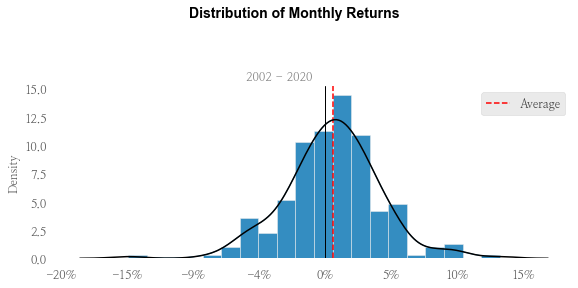

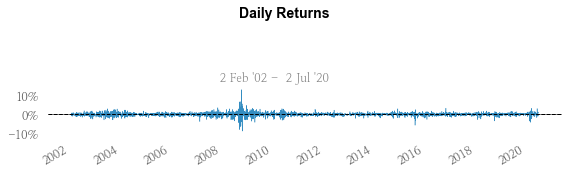

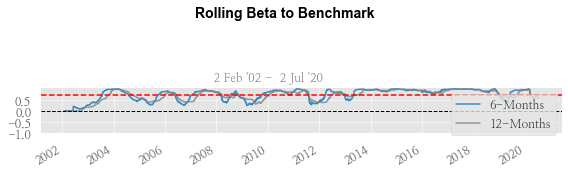

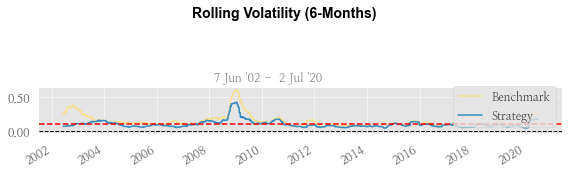

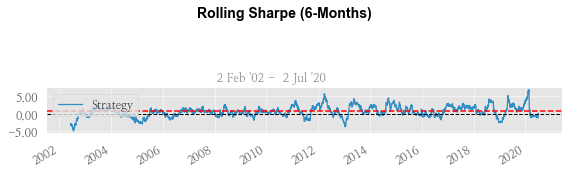

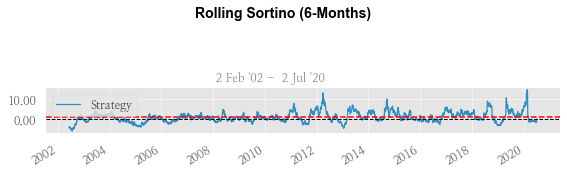

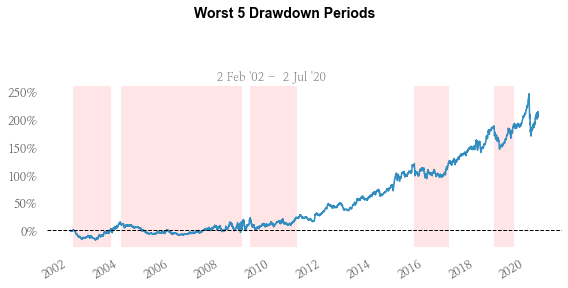

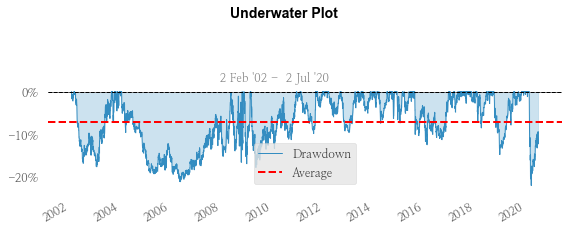

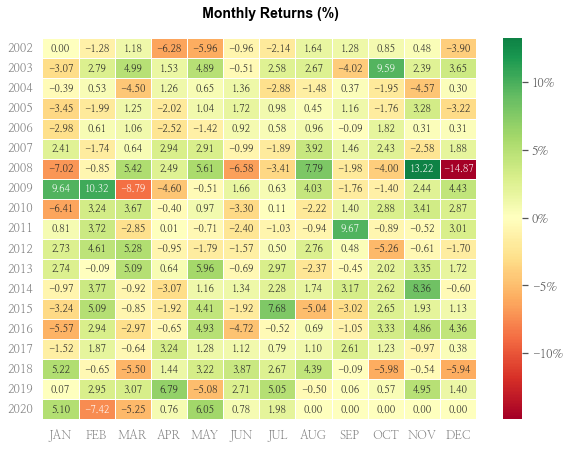

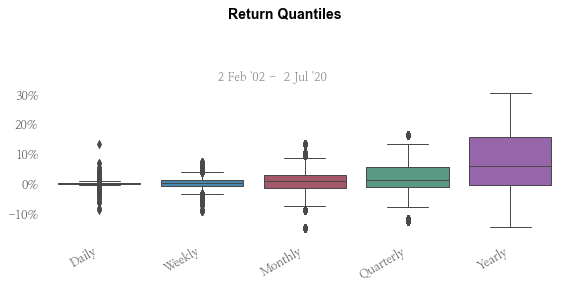

In [53]:
qs.reports.full(r['SPY나스닥동일비중AMS'].prices.to_returns().dropna(), 
                r['SPY나스닥동일비중'].prices.to_returns().dropna())